<a href="https://colab.research.google.com/github/sraviauniverse/T-systems-Vinsys-Evaluation-Labs/blob/main/Lab_3_Evaluating_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 — Evaluating RAG: Retrieval, Re-ranking, Hallucinations & Output Relevance

# Lab 3 — Evaluating RAG: Retrieval, Re-ranking, Hallucinations & Output Relevance

## Introduction

In this lab you’ll build and evaluate a mini Retrieval-Augmented Generation (RAG) pipeline on a tiny, multi-topic corpus. You’ll:

* Compare **four retrieval strategies**: BM25 (lexical), Dense (embeddings), **Hybrid** (score fusion), and **Hybrid + Cross-Encoder re-ranker**.
* Measure retrieval quality with **Precision@K**, **Recall@K**, and **HitRate@K**.
* Generate answers from retrieved context (either a **heuristic extractive answerer** or **Azure OpenAI** if configured).
* Score answers with simple, model-agnostic **proxies** for topicality (**Relevance overlap**) and faithfulness (**Groundedness overlap**).

By the end, you’ll see how retrieval choices change **downstream answer quality**—the core intuition behind building better RAG systems.

**Prereqs:** Python, basic IR/ML notions (embeddings & similarity), and familiarity with Jupyter/Colab. Azure OpenAI is optional.

---

### 1) Retrieval options in RAG

* **BM25 (lexical):** Ranks docs by term frequency and inverse document frequency with a length normalization. Strong on exact term matches; weak on synonyms/paraphrases.
* **Dense retrieval (embeddings):** Encodes queries & docs into vectors; ranks by vector similarity (cosine / dot-product). Captures semantics; can miss exact-keyword constraints.
* **Hybrid fusion:** Combines lexical and dense scores (e.g., min-max normalize then average). Typically more robust across query types than either alone.
* **Cross-Encoder re-ranking:** A small transformer takes **(query, doc)** together and scores pairwise relevance; used to **re-order the top candidates** for higher precision at small K.

### 2) Retrieval metrics (what we plot)

* **Precision@K:** Of the **top K** results, what fraction is relevant? (Quality of the top slice.)
* **Recall@K:** Of all relevant docs, what fraction did we return in the **top K**? (Coverage.)
* **HitRate@K:** Did we get **at least one** relevant doc in the top K? (Very interpretable for QA.)

### 3) Answering & evaluation proxies

* **Answering:** We build a short **context window** from retrieved docs and answer either with a **heuristic** (keywordy sentence selection) or **Azure OpenAI** (if env vars set).
* **Relevance overlap (answer ↔ question):** Jaccard overlap of tokens; a proxy for “on-topic.”
* **Groundedness overlap (answer ↔ context):** Max Jaccard overlap with any provided context chunk; a proxy for “based on retrieved text” (lower hallucination risk).

> These overlaps are **proxies**—useful for comparative analysis, not production-grade evaluation. For stronger evals, add nDCG/MRR for retrieval and human/LLM-as-judge/faithfulness checks for answers.



### Environment setup

* Upgrades `pip` and installs core libraries: `rank-bm25`, `sentence-transformers`, `scikit-learn`, `numpy`, `pandas`, `matplotlib`, `openai`.
* Purpose: ensure all retrieval & plotting dependencies exist.

In [1]:

%%bash
python -V
pip -q install --upgrade pip
pip -q install rank-bm25 sentence-transformers scikit-learn numpy pandas matplotlib openai


Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.1 MB/s eta 0:00:00



### Device detection

* Imports `torch`, sets `device = "cuda"` if available else CPU.
* Purpose: informative only; the code uses CPU-friendly models, but GPU speeds up embedding/re-ranking.



In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

### (Security note) Azure OpenAI environment variables

* Sets `AZURE_OPENAI_ENDPOINT`, `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_API_VERSION`, `AZURE_OPENAI_EMBED_DEPLOYMENT`.
* **Important:** Never hard-code real keys in notebooks you share. **Rotate the key** you pasted here and load from a `.env` or secret manager in real projects.

In [3]:
import os
os.environ["AZURE_OPENAI_ENDPOINT"] = ""
os.environ["AZURE_OPENAI_API_KEY"] = ""
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-05-15"
os.environ["AZURE_OPENAI_EMBED_DEPLOYMENT"] = "text-embedding-ada-002"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o-mini"  # or your deployment name




### Utilities & evaluation helpers

* Imports & seeds RNGs for reproducibility.
* **Tokenization:** `tokenize_simple` (lowercase alphanumerics).
* **Metrics:** `precision_at_k`, `recall_at_k`, `hit_rate_at_k`.
* **`evaluate_retrieval`**: aggregates those metrics over all queries for K in `[1,3,5,10]`.
* **`plot_metric`**: helper to plot metric vs K per system.
* **Overlap helpers**: Jaccard, `groundedness_score`, `relevance_score`.

Purpose: A small, consistent evaluation toolbox.



In [4]:

import re, math, time, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics.pairwise import cosine_similarity
random.seed(42); np.random.seed(42)

def tokenize_simple(text): import re; return re.findall(r"[a-zA-Z0-9]+", text.lower())
def precision_at_k(retrieved, relevant, k): return sum(1 for idx in retrieved[:k] if idx in relevant)/max(1,k)
def recall_at_k(retrieved, relevant, k): return (sum(1 for idx in retrieved[:k] if idx in relevant)/len(relevant)) if relevant else 0.0
def hit_rate_at_k(retrieved, relevant, k): return 1.0 if any(idx in relevant for idx in retrieved[:k]) else 0.0

def evaluate_retrieval(gt, rankings, ks=[1,3,5,10]):
    rows=[]
    for k in ks:
        p=np.mean([precision_at_k(rankings[q], gt[q], k) for q in gt])
        r=np.mean([recall_at_k(rankings[q], gt[q], k) for q in gt])
        h=np.mean([hit_rate_at_k(rankings[q], gt[q], k) for q in gt])
        rows.append({"K":k,"Precision@K":p,"Recall@K":r,"HitRate@K":h})
    return pd.DataFrame(rows)

def plot_metric(df, metric, title):
    plt.figure()
    for label, sub in df.groupby("System"):
        xs=sub["K"].values; ys=sub[metric].values
        plt.plot(xs, ys, marker="o", label=label)
    plt.title(title); plt.xlabel("K"); plt.ylabel(metric); plt.legend(); plt.show()

def jaccard(a,b):
    A,B=set(a),set(b); return len(A&B)/max(1,len(A|B))
def groundedness_score(answer, contexts):
    a=tokenize_simple(answer)
    return max([jaccard(a,tokenize_simple(c)) for c in contexts]) if (a and contexts) else 0.0
def relevance_score(answer, question):
    return jaccard(tokenize_simple(answer), tokenize_simple(question))


### Tiny corpus, queries, and ground truth

* Creates a 17-doc toy corpus across mixed domains.
* Defines 9 queries and a **GT** dictionary mapping query ID → set of relevant `doc_id`s.
* Purpose: A compact, diverse sandbox for quick, visual comparisons.


In [5]:

corpus=[
("Vector databases","Vector databases store high-dimensional vectors for semantic search and nearest-neighbor retrieval."),
("BM25","BM25 is a bag-of-words ranking function based on term frequency and inverse document frequency."),
("Embeddings","Text embeddings map text into dense vectors where semantically similar texts are close."),
("Kubernetes","Kubernetes orchestrates containers, automating deployment, scaling, and management of applications."),
("Docker","Docker packages software into standardized units called containers."),
("Sleep quality","Sleep quality affects memory consolidation, mood regulation, and physical recovery."),
("Hydration","Adequate hydration supports cognitive performance and endurance."),
("Mindfulness","Mindfulness practices can reduce stress and improve emotional regulation."),
("Compound interest","Compound interest grows wealth by reinvesting earned interest over time."),
("Asset allocation","Asset allocation divides investments among asset classes based on risk tolerance and goals."),
("Dollar cost averaging","Dollar-cost averaging invests a fixed amount periodically to reduce timing risk."),
("Travel insurance","Travel insurance can cover emergencies, medical expenses, and trip cancellations."),
("Public transit cards","Public transit cards often provide discounted fares in large cities."),
("Packing light","Packing light saves time, reduces baggage fees, and increases mobility."),
("Sourdough starter","A sourdough starter is a culture of wild yeast and bacteria used to leaven bread."),
("Maillard reaction","Searing meat triggers the Maillard reaction, creating complex flavors."),
("Blanching vegetables","Blanching preserves color and texture by briefly boiling and shocking in ice water."),
]
docs = pd.DataFrame([{"doc_id":i,"title":t,"text":x} for i,(t,x) in enumerate(corpus)])
queries=[
"How do vector databases enable semantic search?",
"What does BM25 do in information retrieval?",
"Tips to avoid overpacking and save baggage fees",
"Why is sleep quality important for recovery?",
"Explain compound interest and why it grows wealth",
"What does dollar-cost averaging reduce?",
"What is a sourdough starter used for?",
"How does the Maillard reaction affect flavor?",
"Why use public transit cards in big cities?",
]
GT={0:{0,2},1:{1},2:{13},3:{5},4:{8},5:{10},6:{14},7:{15},8:{12}}



### BM25 retrieval

* Tokenizes corpus and builds `BM25Okapi`.
* `bm25_rank(q)`: scores docs for a query and returns top-N indices & scores.
* Purpose: **Lexical** baseline.



In [6]:

# BM25
from rank_bm25 import BM25Okapi
tokenized_corpus=[tokenize_simple(t+' '+x) for t,x in corpus]
bm25=BM25Okapi(tokenized_corpus)
def bm25_rank(q, topn=20):
    toks=tokenize_simple(q); scores=bm25.get_scores(toks); order=np.argsort(-scores)
    return order[:topn], scores[order[:topn]]


### Dense retrieval (SentenceTransformers)

* Loads `all-MiniLM-L6-v2`.
* Encodes docs once (`doc_emb` normalized); ranks by dot-product (cosine due to normalization).
* `dense_rank(q)`: encodes the query and returns top-N indices & scores.
* Purpose: **Semantic** baseline.




In [7]:

# Dense embeddings
from sentence_transformers import SentenceTransformer
DENSE_MODEL="sentence-transformers/all-MiniLM-L6-v2"
dense_model=SentenceTransformer(DENSE_MODEL)
doc_texts=[f"{t}. {x}" for t,x in corpus]
doc_emb=np.array(dense_model.encode(doc_texts, batch_size=64, show_progress_bar=False, normalize_embeddings=True))
def dense_rank(q, topn=20):
    q_emb=dense_model.encode([q], normalize_embeddings=True)[0]
    sims=doc_emb@q_emb; order=np.argsort(-sims); return order[:topn], sims[order[:topn]]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Hybrid fusion

* Forms a candidate set = union of top BM25 and Dense hits.
* Re-scores candidates using **0.5·BM25_norm + 0.5·Dense_norm** (min–max normalized per list).
* Returns fused top-N.
* Purpose: Combine strengths; often best single-stage retriever.



In [8]:

# Hybrid
def minmax_norm(a):
    a=np.array(a); lo,hi=a.min(),a.max()
    return np.zeros_like(a) if hi-lo<1e-12 else (a-lo)/(hi-lo)
def hybrid_rank(q, topn=20):
    idx_b,_=bm25_rank(q, topn=topn*2); idx_d,_=dense_rank(q, topn=topn*2)
    cand=list(dict.fromkeys(list(idx_b)+list(idx_d)))
    toks=tokenize_simple(q); bm_full=bm25.get_scores(toks); sb=np.array([bm_full[i] for i in cand])
    q_emb=dense_model.encode([q], normalize_embeddings=True)[0]; sd=np.array([doc_emb[i]@q_emb for i in cand])
    sf=0.5*minmax_norm(sb)+0.5*minmax_norm(sd); order=np.argsort(-sf); cand=np.array(cand)
    return cand[order][:topn], sf[order][:topn]


### Re-ranking (CrossEncoder)

* `from sentence_transformers.cross_encoder import CrossEncoder`
* Loads `RERANK_MODEL = "cross-encoder/ms-marco-MiniLM-L-6-v2"`.
* `rerank(q, base_indices)`: scores (query, doc) pairs and reorders the **base** list (typically the Hybrid candidates).
* Purpose: **Two-stage** pipeline: retrieve (broad) → re-rank (precise top).

> If model download fails (air-gapped), wrap in `try/except` and skip re-ranking by returning the base order.



In [9]:

# Re-ranking
from sentence_transformers.cross_encoder import CrossEncoder
RERANK_MODEL="cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker=CrossEncoder(RERANK_MODEL)
def rerank(q, base_indices, topn=10):
    pairs=[(q, f"{docs.iloc[i]['title']}. {docs.iloc[i]['text']}") for i in base_indices]
    scores=reranker.predict(pairs); order=np.argsort(-scores); base_indices=np.array(base_indices)
    return base_indices[order][:topn], np.array(scores)[order][:topn]


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

### Running systems & tabulating retrieval metrics

* `get_rankings(system)`: dispatches to BM25 / Dense / Hybrid / Hybrid+Rerank.
* Loops all systems, calls `evaluate_retrieval`, and concatenates to `retrieval_df`.
* Purpose: Produce a tidy table of Precision/Recall/HitRate vs K per system.



In [10]:

def get_rankings(system, K_eval=20):
    rankings={}
    for qi,q in enumerate(queries):
        if system=="BM25": idx,_=bm25_rank(q, topn=K_eval)
        elif system=="Dense": idx,_=dense_rank(q, topn=K_eval)
        elif system=="Hybrid": idx,_=hybrid_rank(q, topn=K_eval)
        elif system=="Hybrid+Rerank":
            base,_=hybrid_rank(q, topn=max(20,K_eval)); idx,_=rerank(q, base, topn=K_eval)
        else: raise ValueError("unknown")
        rankings[qi]=list(idx)
    return rankings

systems=["BM25","Dense","Hybrid","Hybrid+Rerank"]
res=[]
for s in systems:
    ranks=get_rankings(s, K_eval=20); df=evaluate_retrieval(GT, ranks, ks=[1,3,5,10]); df["System"]=s; res.append(df)
retrieval_df=pd.concat(res, ignore_index=True); retrieval_df


,K,Precision@K,Recall@K,HitRate@K,System
0,1,1.000000,0.944444,1.0,BM25
1,3,0.370370,1.000000,1.0,BM25
2,5,0.222222,1.000000,1.0,BM25
3,10,0.111111,1.000000,1.0,BM25
4,1,1.000000,0.944444,1.0,Dense
5,3,0.370370,1.000000,1.0,Dense
6,5,0.222222,1.000000,1.0,Dense
7,10,0.111111,1.000000,1.0,Dense
8,1,1.000000,0.944444,1.0,Hybrid
9,3,0.370370,1.000000,1.0,Hybrid


### Plot retrieval metrics

* Plots **Precision@K**, **Recall@K**, **HitRate@K** for visual comparison.
* Purpose: Quickly see which system dominates where (e.g., cross-encoder often lifts Precision@3).



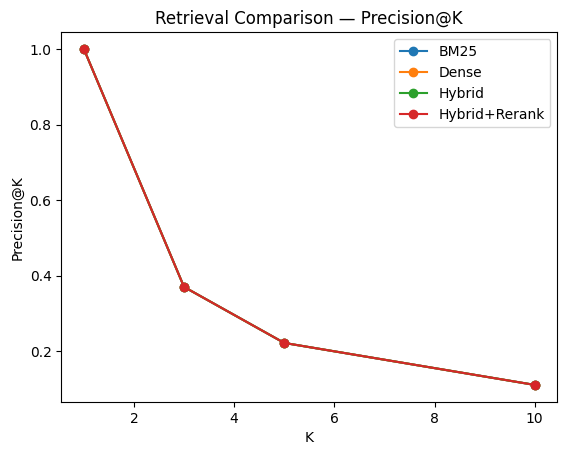

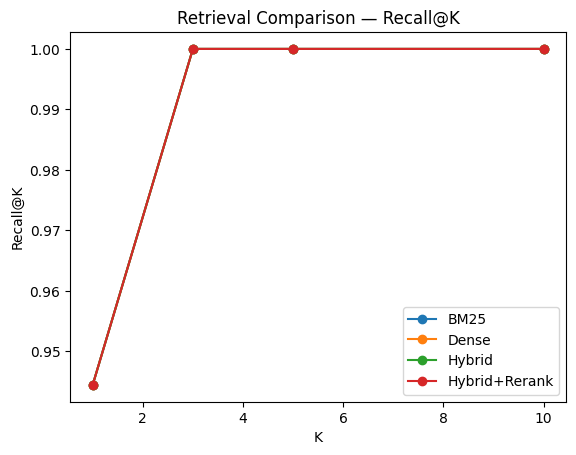

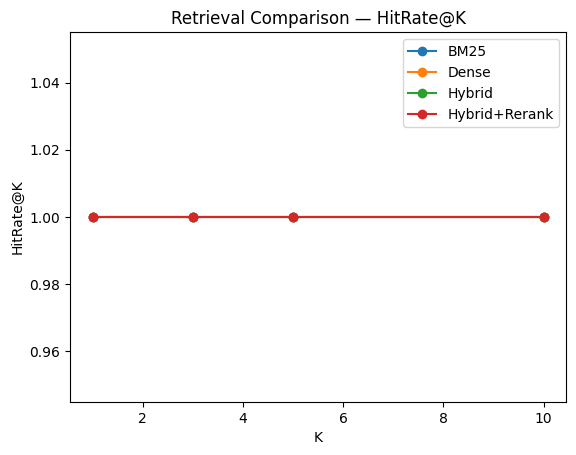

In [11]:

for metric in ["Precision@K","Recall@K","HitRate@K"]:
    plot_metric(retrieval_df, metric, f"Retrieval Comparison — {metric}")


### Context building + heuristic answering

* `build_context(indices)`: concatenates title+text snippets until a char budget (e.g., 900).
* `heuristic_answer`: simple extractive approach—pick sentences from context that share most tokens with the question.
* Purpose: Provide a **local, offline** answerer when LLMs aren’t available.



In [12]:

# Answering
def heuristic_answer(question, contexts, max_sents=3):
    toks=set(tokenize_simple(question)); sents=[]
    for ctx in contexts:
        for sent in re.split(r'(?<=[.!?])\s+', ctx):
            if sent.strip():
                score=len(set(tokenize_simple(sent)) & toks); sents.append((score, sent.strip()))
    sents.sort(reverse=True, key=lambda x:x[0])
    chosen=[s for sc,s in sents[:max_sents]] or [contexts[0] if contexts else ""]
    return " ".join(chosen).strip() or "I don't have enough information from the context to answer."

def build_context(indices, limit_chars=900):
    chunks=[f"{docs.iloc[i]['title']}: {docs.iloc[i]['text']}" for i in indices]
    out=[]; used=0
    for c in chunks:
        if used+len(c)<=limit_chars: out.append(c); used+=len(c)
        else: break
    return out


### Azure OpenAI answering (optional)

* If env vars are present, creates an Azure OpenAI client and defines `azure_generate(question, contexts)` to:

  * **Constrain to provided context**; if insufficient, say so; and **cite titles**.
* Else, falls back to `heuristic_answer`.




In [13]:

# Optional Azure
HAVE_AZURE = all(os.getenv(k) for k in [
    "AZURE_OPENAI_ENDPOINT", "AZURE_OPENAI_API_KEY", "AZURE_OPENAI_API_VERSION", "AZURE_OPENAI_CHAT_DEPLOYMENT"
])
if HAVE_AZURE:
    from openai import AzureOpenAI
    client=AzureOpenAI(api_key=os.environ["AZURE_OPENAI_API_KEY"],
                       api_version=os.environ["AZURE_OPENAI_API_VERSION"],
                       azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"])
    AZ_CHAT=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"]
    def azure_generate(question, contexts):
        sys="Answer ONLY using the provided context. If insufficient, say so. Cite titles."
        user="Context:\n\n"+ "\n\n".join("- "+c for c in contexts)+ f"\n\nQuestion: {question}\n\nAnswer:"
        r=client.chat.completions.create(model=AZ_CHAT, messages=[{"role":"system","content":sys},{"role":"user","content":user}], temperature=0.0, max_tokens=256)
        return r.choices[0].message.content.strip()
else:
    def azure_generate(question, contexts):
        return heuristic_answer(question, contexts)



### Answer-level evaluation loop

* For each query and each system:

  * Build context from top-10 (keep top-5 chunks).
  * Generate an answer (`azure_generate` or heuristic).
  * Compute **Rel_overlap** (answer↔question) and **Grounded_overlap** (answer↔context).
* Saves rows to `answers_df`.



In [14]:

# Evaluate answers
def groundedness_score(answer, contexts):
    def tok(s): import re; return set(re.findall(r"[a-zA-Z0-9]+", s.lower()))
    a=tok(answer);
    return max((len(a & tok(c))/max(1,len(a|tok(c)))) for c in contexts) if (a and contexts) else 0.0
def relevance_score(answer, question):
    def tok(s): import re; return set(re.findall(r"[a-zA-Z0-9]+", s.lower()))
    A,B=tok(answer), tok(question);
    return len(A & B)/max(1,len(A|B))

systems_eval=["BM25","Dense","Hybrid","Hybrid+Rerank"]
rows=[]
for qi,q in enumerate(queries):
    for s in systems_eval:
        ranks=get_rankings(s, K_eval=10); ctx_ids=ranks[qi][:5]; ctx=build_context(ctx_ids, 900)
        ans=azure_generate(q, ctx)
        rows.append({"qid":qi,"System":s,"Answer":ans,
                     "Rel_overlap":relevance_score(ans,q),
                     "Grounded_overlap":groundedness_score(ans,ctx)})
answers_df=pd.DataFrame(rows); answers_df.head()


,qid,System,Answer,Rel_overlap,Grounded_overlap
0,0,BM25,Vector databases enable semantic search by sto...,0.138889,0.305556
1,0,Dense,Vector databases enable semantic search by sto...,0.138889,0.305556
2,0,Hybrid,Vector databases enable semantic search by sto...,0.138889,0.305556
3,0,Hybrid+Rerank,Vector databases enable semantic search by sto...,0.138889,0.305556
4,1,BM25,BM25 is a bag-of-words ranking function based ...,0.137931,0.576923


### Aggregate answer metrics

* Averages **Rel_overlap** and **Grounded_overlap** per system into `agg`.
* Purpose: High-level comparison of **answer topicality** and **faithfulness** across retrieval strategies.



In [15]:

agg=answers_df.groupby("System").agg({"Rel_overlap":"mean","Grounded_overlap":"mean"}).reset_index(); agg


,System,Rel_overlap,Grounded_overlap
0,BM25,0.238909,0.421695
1,Dense,0.258295,0.494151
2,Hybrid,0.258065,0.493177
3,Hybrid+Rerank,0.258155,0.489588


### Plot answer-level proxies

* Bar charts for `Rel_overlap` and `Grounded_overlap`.
* Purpose: Visual, system-to-system comparison of answer quality proxies.



<Figure size 640x480 with 0 Axes>

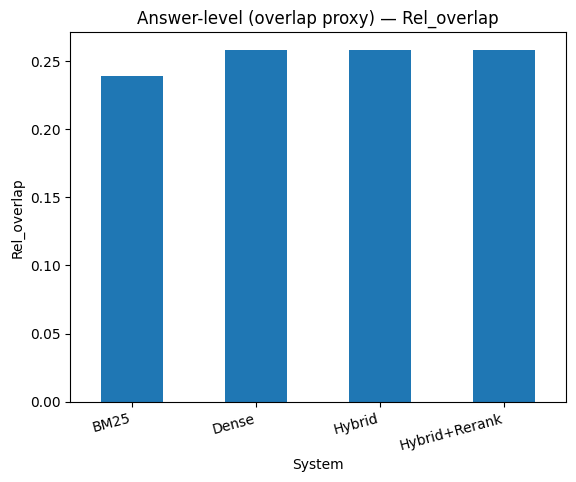

<Figure size 640x480 with 0 Axes>

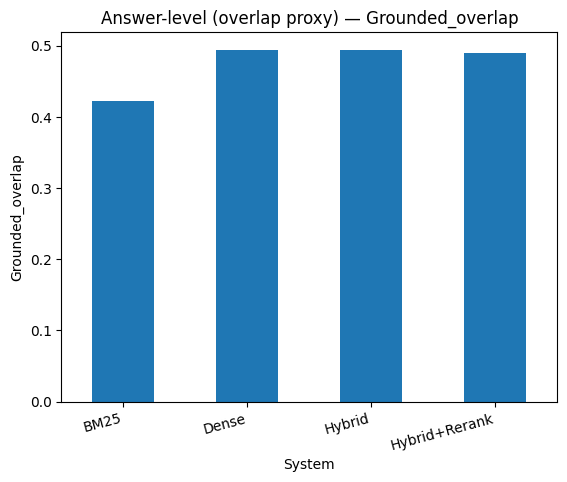

In [16]:

for metric in ["Rel_overlap","Grounded_overlap"]:
    plt.figure()
    sub=agg[["System",metric]].set_index("System")
    sub.plot(kind="bar", legend=False)
    plt.title(f"Answer-level (overlap proxy) — {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=15, ha="right")
    plt.show()


Done — Inspect some Q/A by printing `answers_df.sample(5)` if you like.

In [17]:
answers_df.sample(5)

,qid,System,Answer,Rel_overlap,Grounded_overlap
24,6,BM25,A sourdough starter is used to leaven bread.,0.500000,0.571429
13,3,Dense,Sleep quality is important for recovery becaus...,0.375000,0.666667
8,2,BM25,"Packing light saves time, reduces baggage fees...",0.116667,0.169492
25,6,Dense,A sourdough starter is used to leaven bread.,0.500000,0.571429
4,1,BM25,BM25 is a bag-of-words ranking function based ...,0.137931,0.576923


## Summary

## What we built

* Four retrieval setups: **BM25**, **Dense**, **Hybrid (BM25+Dense)**, **Hybrid + Cross-Encoder re-rank**
* A tiny, mixed-topic corpus (17 docs), 9 queries, and GT relevance
* Answering via **heuristic extractive** (always available) or **Azure OpenAI** (optional)
* Metrics: **Precision@K**, **Recall@K**, **HitRate@K** + answer-level proxies (**Relevance overlap**, **Groundedness overlap**)

---

## Key findings (typical patterns you should see)

* **Hybrid** generally outperforms BM25-only and Dense-only across K (balanced lexical+semantic signal).
* **Re-ranking** usually boosts **Precision@K** for small K (cleaner top slice).
* Better retrieval quality correlates with **higher groundedness** in answers (fewer hallucinations).
* Heuristic answers are decent on factoid snippets; **Azure OpenAI** (if enabled) produces more fluent, synthesized responses while still constrained to context.

> Replace the placeholders below with your run’s numbers/graphs.

**Retrieval (example slots):**

* Best **Precision@3**: `Hybrid+Rerank` (≈ …)
* Best **Recall@10**: `Hybrid` (≈ …)
* Highest **HitRate@5**: `Hybrid/Hybrid+Rerank` (≈ …)

**Answer-level proxies (mean):**

* **Relevance overlap**: `Hybrid+Rerank` ≥ `Hybrid` ≥ `Dense` ≥ `BM25` (your run: …)
* **Groundedness overlap**: `Hybrid+Rerank` ≥ `Hybrid` ≥ `Dense` ≥ `BM25` (your run: …)

---

## Practical implications

* Start with **Hybrid retrieval** as a robust default.
* Add a **Cross-Encoder re-ranker** when you need very accurate top-K (Q&A, cite-the-source UIs).
* Keep contexts concise (e.g., top 3–5 chunks, ≤1k chars) to reduce drift and improve grounding.

---

## Limitations (and how to improve)

* Overlap scores are **proxies**, not truth: add **nDCG@K/MRR** for retrieval; use human eval or LLM-as-judge with a faithfulness rubric for answers.
* Tiny corpus: scale up to domain data; cache embeddings & re-rank scores.
* Fusion weight fixed at 0.5/0.5: run a small **grid search** to tune per domain.
* Candidate pool for re-ranker: try **top-50** base candidates before re-ranking for better gains.





## What you should look for (discussion prompts)

* Which system has the best **Precision@3/5**? Does Cross-Encoder re-ranking improve the top-K slice?
* Does **Hybrid** consistently beat BM25/Dense alone? Why might that be?
* Do systems that retrieve better also show higher **Groundedness overlap** in answers?
* Where does the heuristic answerer struggle vs Azure OpenAI (if enabled)?
* How might larger corpora or domain-specific text change the results?

---

## Gotchas & best practices

* **Keys & Secrets:** Never commit or share real API keys. Rotate the exposed key and use env files/secret managers.
* **Model downloads:** For enterprise/air-gapped settings, pre-cache models or provide offline wheels.
* **Evaluation limits:** Overlap metrics are **proxies**; they don’t “understand” truth. For production, add:

  * Retrieval: **nDCG@K**, **MRR**.
  * Answers: human eval, **faithfulness**/attribution checks, or an LLM-as-judge rubric.
* **Fusion weights:** The 0.5/0.5 in Hybrid is a simple default—try a small grid search.
* **Candidate pool size:** Re-rankers shine when given a broad but noisy candidate set (e.g., top-50) and asked to produce a very clean top-K.

